### Import necessary packages

In [3]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import MNIST data so we have something for our experiments

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural network classes for testing

In [5]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):

        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"

        self.is_training = tf.placeholder(tf.bool, name="is_training")

        self.training_accuracies = []

        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):

        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)    
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
   
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):

        if self.use_batch_norm and activation_fn:

            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)

            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            return activation_fn(batch_normalized_output)
        else:

            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if not activation_fn else activation_fn(linear_output)

    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):

        labels = tf.placeholder(tf.float32, [None, 10])

        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))

        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        if self.use_batch_norm:

            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        for i in tqdm.tqdm(range(training_batches)):

            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
        
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)

        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        print('{}: After training, final accuracy on validation set = {}'.format(self.name, test_accuracy))

        if save_model_as:
            tf.train.Saver().save(session, save_model_as)

    def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):

        labels = tf.placeholder(tf.float32, [None, 10])

        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


        if restore_from:
            tf.train.Saver().restore(session, restore_from)

        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        print('-'*75)
        print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))

        if include_individual_predictions:
            predictions = []
            correct = 0


            for i in range(200):
                pred, corr = session.run([tf.arg_max(self.output_layer,1), accuracy],
                                         feed_dict={self.input_layer: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr

                predictions.append(pred[0])

            print("200 Predictions:", predictions)
            print("Accuracy on 200 samples:", correct/200)

### Code to support testing

In [6]:
def plot_training_accuracies(*args, **kwargs):

    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*batches_per_sample,batches_per_sample),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):

    if use_bad_weights:
        weights = [np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,10), scale=5.0).astype(np.float32)
                  ]
    else:
        weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
                  ]


    tf.reset_default_graph()

    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)

### The following creates two networks using a ReLU activation function, a learning rate of 0.01, and reasonable starting weights.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:55<00:00, 432.86it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9769999980926514


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:20<00:00, 249.43it/s]


With Batch Norm: After training, final accuracy on validation set = 0.982200026512146
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9721999764442444
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.98089998960495


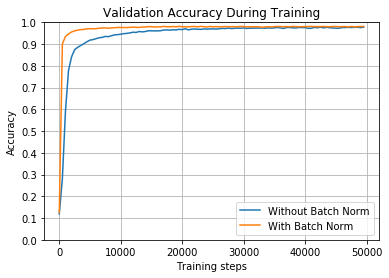

In [7]:
#The following creates two networks using a ReLU activation function, a learning rate of 0.01, and reasonable starting weights.

train_and_test(False, 0.01, tf.nn.relu)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 402.58it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8537999987602234


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 244.74it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9534000158309937
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8508999943733215
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9502999782562256


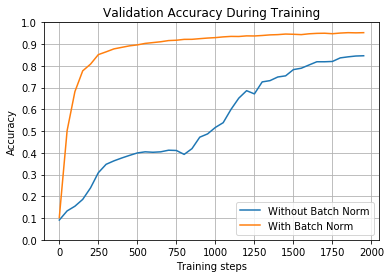

In [8]:
#Used in the previous example, but only trains for 2000 iterations.

train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

### The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and reasonable starting weights.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:51<00:00, 447.94it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8095999956130981


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:30<00:00, 237.95it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9714000225067139
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8034999966621399
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9686999917030334


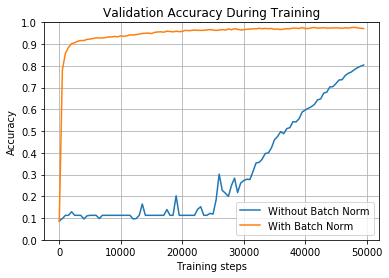

In [9]:
#The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and reasonable starting weights.

train_and_test(False, 0.01, tf.nn.sigmoid)

### The following creates two networks using a ReLU activation function, a learning rate of 1, and reasonable starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:51<00:00, 447.82it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:15<00:00, 255.78it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9805999994277954
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9847000241279602


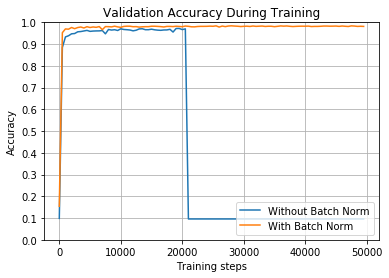

In [10]:
#The following creates two networks using a ReLU activation function, a learning rate of 1, and reasonable starting weights.

train_and_test(False, 1, tf.nn.relu)

### The following creates two networks using a sigmoid activation function, a learning rate of 1, and reasonable starting weights.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:53<00:00, 440.48it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9787999987602234


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 244.72it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9800000190734863
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9779999852180481
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9785000085830688


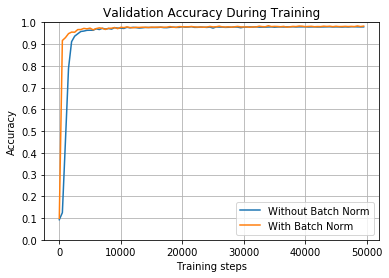

In [11]:
#The following creates two networks using a sigmoid activation function, a learning rate of 1, and reasonable starting weights.

train_and_test(False, 1, tf.nn.sigmoid)


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 412.71it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9186000227928162


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.75it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9517999887466431
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9071000218391418
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9465000033378601


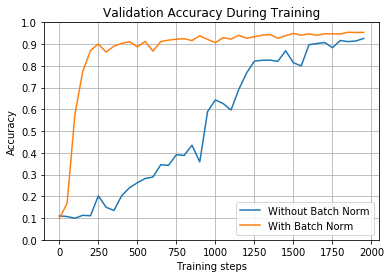

In [12]:
#shows a similar pair of networks trained for only 2000 iterations.

train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

### The following creates two networks using a ReLU activation function, a learning rate of 2, and reasonable starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:52<00:00, 445.16it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0989999994635582


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:21<00:00, 248.52it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9833999872207642
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.10090000182390213
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9818000197410583


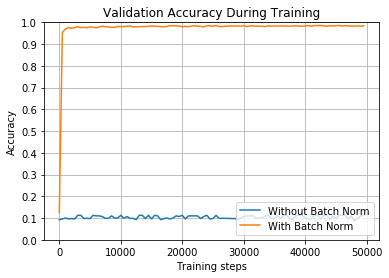

In [13]:
#The following creates two networks using a ReLU activation function, a learning rate of 2, and reasonable starting weights.

train_and_test(False, 2, tf.nn.relu)

### The following creates two networks using a sigmoid activation function, a learning rate of 2, and reasonable starting weights.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:57<00:00, 426.64it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9800000190734863


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:28<00:00, 240.22it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9824000000953674
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9781000018119812
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9799000024795532


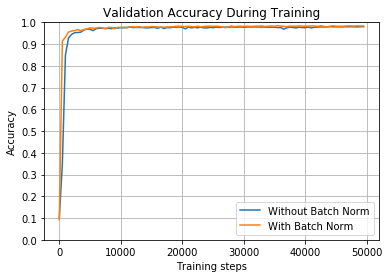

In [14]:
#The following creates two networks using a sigmoid activation function, a learning rate of 2, and reasonable starting weights.

train_and_test(False, 2, tf.nn.sigmoid)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 388.81it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9477999806404114


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.32it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9628000259399414
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.944599986076355
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9581000208854675


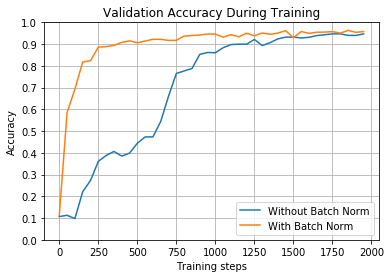

In [15]:
#shows a similar pair of networks trained for only 2000 iterations.

train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

### The following creates two networks using a ReLU activation function, a learning rate of 0.01, and bad starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:55<00:00, 434.05it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999871253967


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:25<00:00, 243.65it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8145999908447266
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8123000264167786


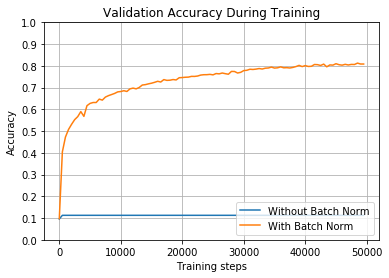

In [16]:
#The following creates two networks using a ReLU activation function, a learning rate of 0.01, and bad starting weights.

train_and_test(True, 0.01, tf.nn.relu)

### The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and bad starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:58<00:00, 423.21it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.4203999936580658


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:29<00:00, 238.46it/s]


With Batch Norm: After training, final accuracy on validation set = 0.850600004196167
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.40130001306533813
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.849399983882904


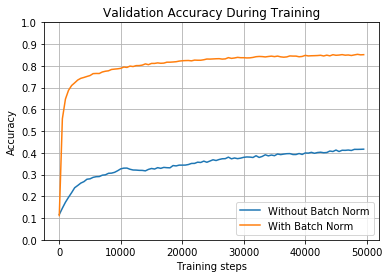

In [17]:
#The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and bad starting weights.

train_and_test(True, 0.01, tf.nn.sigmoid)

### The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:53<00:00, 438.99it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999871253967


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:23<00:00, 245.28it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8820000290870667
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8841999769210815


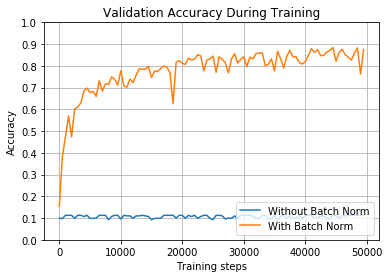

In [18]:
#The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.

train_and_test(True, 1, tf.nn.relu)

### The following creates two networks using a sigmoid activation function, a learning rate of 1, and bad starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:56<00:00, 430.55it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.902999997138977


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 245.02it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9581999778747559
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9035000205039978
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9491999745368958


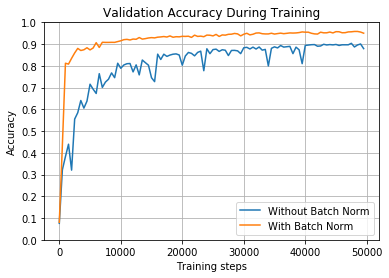

In [19]:
#The following creates two networks using a sigmoid activation function, a learning rate of 1, and bad starting weights.

train_and_test(True, 1, tf.nn.sigmoid)

### The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:56<00:00, 428.71it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 244.94it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8055999875068665
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.7944999933242798


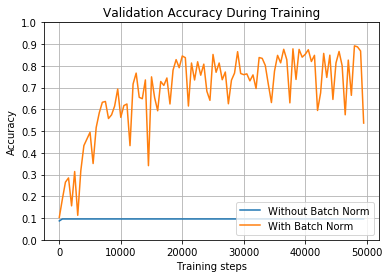

In [20]:
#The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.

train_and_test(True, 2, tf.nn.relu)

### The following creates two networks using a sigmoid activation function, a learning rate of 2, and bad starting weights.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:53<00:00, 441.87it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9111999869346619


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 244.38it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9577999711036682
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.902899980545044
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9545999765396118


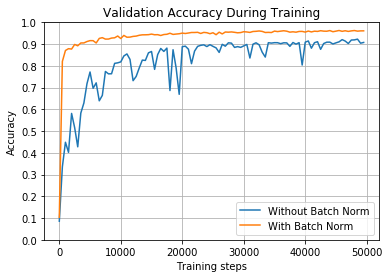

In [21]:
#The following creates two networks using a sigmoid activation function, a learning rate of 2, and bad starting weights.

train_and_test(True, 2, tf.nn.sigmoid)

## Batch Normalization Doesn't Fix Everything
### The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:55<00:00, 431.10it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999871253967


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:25<00:00, 243.04it/s]


With Batch Norm: After training, final accuracy on validation set = 0.842199981212616
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8392999768257141


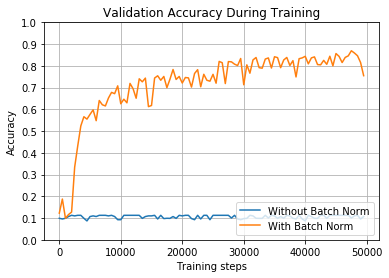

In [22]:
#Full Disclosure: Batch Normalization Doesn't Fix Everything
#The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.

train_and_test(True, 1, tf.nn.relu)

### The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:57<00:00, 426.22it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 244.65it/s]


With Batch Norm: After training, final accuracy on validation set = 0.0957999974489212
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.09799999743700027


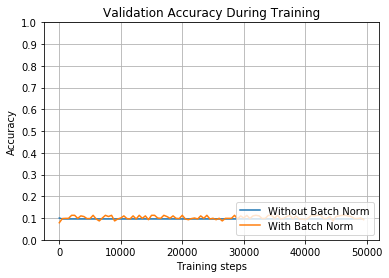

In [23]:
#The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.

train_and_test(True, 2, tf.nn.relu)

## Batch normalization without the tf.layers package
### Low Level Implementation

In [24]:
#Batch normalization without the tf.layers package

def fully_connected(self, layer_in, initial_weights, activation_fn=None):

    if self.use_batch_norm and activation_fn:

        weights = tf.Variable(initial_weights)
        linear_output = tf.matmul(layer_in, weights)

        num_out_nodes = initial_weights.shape[-1]

        gamma = tf.Variable(tf.ones([num_out_nodes]))
        beta = tf.Variable(tf.zeros([num_out_nodes]))

        pop_mean = tf.Variable(tf.zeros([num_out_nodes]), trainable=False)
        pop_variance = tf.Variable(tf.ones([num_out_nodes]), trainable=False)

        epsilon = 1e-3

        def batch_norm_training():

            batch_mean, batch_variance = tf.nn.moments(linear_output, [0])

            decay = 0.99
            train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
            train_variance = tf.assign(pop_variance, pop_variance * decay + batch_variance * (1 - decay))

            with tf.control_dependencies([train_mean, train_variance]):
                return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
 
        def batch_norm_inference():

            return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)

        batch_normalized_output = tf.cond(self.is_training, batch_norm_training, batch_norm_inference)

        return activation_fn(batch_normalized_output)
    else:

        weights = tf.Variable(initial_weights)
        biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
        linear_output = tf.add(tf.matmul(layer_in, weights), biases)
        return linear_output if not activation_fn else activation_fn(linear_output)

To use the lower level implementation, it is adviced to switch the following line of code in the NeuralNetwork class:
    
```python
if self.use_batch_norm:
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
else:
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```
    with the follwing:
```python
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```


In addition, 
to implement the normalization function from scratch you will replace the following script in batch_norm_training:
```python
return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
```
    with the follwing:
```python
normalized_linear_output = (linear_output - batch_mean) / tf.sqrt(batch_variance + epsilon)
return gamma * normalized_linear_output + beta
```

Also replacing the following line of script in batch_norm_inference:

```python
return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)

```
    with the follwing:
```python
normalized_linear_output = (linear_output - pop_mean) / tf.sqrt(pop_variance + epsilon)
return gamma * normalized_linear_output + beta
```
